In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import keras
from keras_unet.models import custom_unet


2023-01-08 19:31:43.766183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
labels = labels.astype(np.float64)

In [10]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


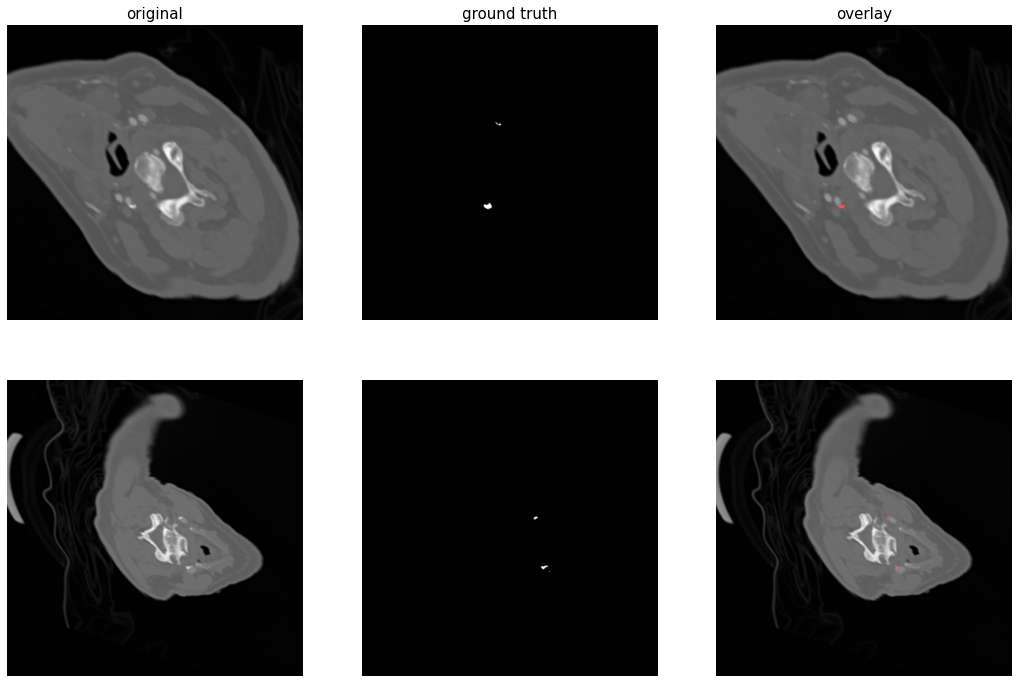

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [15]:

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-01-08 19:31:54.278885: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-08 19:31:54.370665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-08 19:31:54.370705: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-08 19:31:54.379563: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-08 19:31:54.379596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-08 19:31:54.381312: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [17]:
from tensorflow import keras
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

In [18]:
from keras.callbacks import EarlyStopping

earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [19]:

from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [20]:
opt = keras.optimizers.Adam(learning_rate=lr_schedule,)

In [21]:
model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [22]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=1000,
                    validation_data=(X_val, y_val),
                    callbacks = [earlystopping])

2023-01-08 19:31:56.035082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-08 19:31:56.053176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/1000


2023-01-08 19:31:57.229935: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-08 19:31:57.854566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-01-08 19:31:58.513603: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-01-08 19:31:58.513628: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-01-08 19:31:58.513692: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-08 19:31:58.596135: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-08 19:31:59.296983: I tensorflow/stream_exec

10/10 [==============================] - 42s 2s/step - loss: 0.1793 - iou: 7.6212e-05 - iou_thresholded: 5.6863e-04 - val_loss: 0.0667 - val_iou: 5.9662e-06 - val_iou_thresholded: 0.0019
Epoch 2/1000
10/10 [==============================] - 10s 960ms/step - loss: 0.0248 - iou: 1.2309e-04 - iou_thresholded: 5.6944e-04 - val_loss: 0.0143 - val_iou: 2.8942e-05 - val_iou_thresholded: 0.0019
Epoch 3/1000
10/10 [==============================] - 10s 954ms/step - loss: 0.0081 - iou: 1.8839e-04 - iou_thresholded: 5.5238e-04 - val_loss: 0.0029 - val_iou: 3.7459e-04 - val_iou_thresholded: 0.0019
Epoch 4/1000
10/10 [==============================] - 10s 953ms/step - loss: 0.0042 - iou: 3.1091e-04 - iou_thresholded: 5.8324e-04 - val_loss: 0.0057 - val_iou: 1.8080e-04 - val_iou_thresholded: 0.0019
Epoch 5/1000
10/10 [==============================] - 10s 962ms/step - loss: 0.0035 - iou: 2.1293e-04 - iou_thresholded: 5.8434e-04 - val_loss: 0.0045 - val_iou: 2.4771e-04 - val_iou_thresholded: 0.0019
E

Epoch 43/1000
10/10 [==============================] - 10s 951ms/step - loss: 0.0014 - iou: 0.0412 - iou_thresholded: 0.0463 - val_loss: 0.0010 - val_iou: 0.0477 - val_iou_thresholded: 0.0124
Epoch 44/1000
10/10 [==============================] - 10s 954ms/step - loss: 0.0011 - iou: 0.0428 - iou_thresholded: 0.0254 - val_loss: 9.5769e-04 - val_iou: 0.0538 - val_iou_thresholded: 0.0215
Epoch 45/1000
10/10 [==============================] - 10s 956ms/step - loss: 8.7783e-04 - iou: 0.0948 - iou_thresholded: 0.0935 - val_loss: 8.4017e-04 - val_iou: 0.1095 - val_iou_thresholded: 0.0970
Epoch 46/1000
10/10 [==============================] - 10s 952ms/step - loss: 7.6336e-04 - iou: 0.1436 - iou_thresholded: 0.1891 - val_loss: 7.5551e-04 - val_iou: 0.1555 - val_iou_thresholded: 0.1742
Epoch 47/1000
10/10 [==============================] - 10s 956ms/step - loss: 7.1466e-04 - iou: 0.1787 - iou_thresholded: 0.2545 - val_loss: 7.1649e-04 - val_iou: 0.1722 - val_iou_thresholded: 0.2044
Epoch 48/100

10/10 [==============================] - 10s 952ms/step - loss: 3.7922e-04 - iou: 0.4122 - iou_thresholded: 0.5388 - val_loss: 4.2095e-04 - val_iou: 0.3779 - val_iou_thresholded: 0.5286
Epoch 85/1000
10/10 [==============================] - 10s 960ms/step - loss: 3.6288e-04 - iou: 0.4145 - iou_thresholded: 0.5411 - val_loss: 4.1933e-04 - val_iou: 0.3976 - val_iou_thresholded: 0.5231
Epoch 86/1000
10/10 [==============================] - 10s 953ms/step - loss: 3.5846e-04 - iou: 0.4297 - iou_thresholded: 0.5498 - val_loss: 4.0271e-04 - val_iou: 0.3894 - val_iou_thresholded: 0.5328
Epoch 87/1000
10/10 [==============================] - 10s 953ms/step - loss: 3.5556e-04 - iou: 0.4185 - iou_thresholded: 0.5401 - val_loss: 4.1812e-04 - val_iou: 0.3835 - val_iou_thresholded: 0.5318
Epoch 88/1000
10/10 [==============================] - 10s 954ms/step - loss: 3.5941e-04 - iou: 0.4172 - iou_thresholded: 0.5472 - val_loss: 4.1659e-04 - val_iou: 0.4235 - val_iou_thresholded: 0.5090
Epoch 89/1000


Epoch 125/1000
10/10 [==============================] - 10s 951ms/step - loss: 2.5414e-04 - iou: 0.5262 - iou_thresholded: 0.6336 - val_loss: 3.6956e-04 - val_iou: 0.4684 - val_iou_thresholded: 0.5748
Epoch 126/1000
10/10 [==============================] - 10s 953ms/step - loss: 2.4859e-04 - iou: 0.5326 - iou_thresholded: 0.6376 - val_loss: 3.7293e-04 - val_iou: 0.4561 - val_iou_thresholded: 0.5714
Epoch 127/1000
10/10 [==============================] - 9s 950ms/step - loss: 2.4208e-04 - iou: 0.5402 - iou_thresholded: 0.6541 - val_loss: 3.7780e-04 - val_iou: 0.4625 - val_iou_thresholded: 0.5760
Epoch 128/1000
10/10 [==============================] - 10s 954ms/step - loss: 2.3327e-04 - iou: 0.5521 - iou_thresholded: 0.6633 - val_loss: 3.7346e-04 - val_iou: 0.4777 - val_iou_thresholded: 0.5678
Epoch 129/1000
10/10 [==============================] - 10s 961ms/step - loss: 2.4686e-04 - iou: 0.5363 - iou_thresholded: 0.6450 - val_loss: 4.2946e-04 - val_iou: 0.4883 - val_iou_thresholded: 0.5

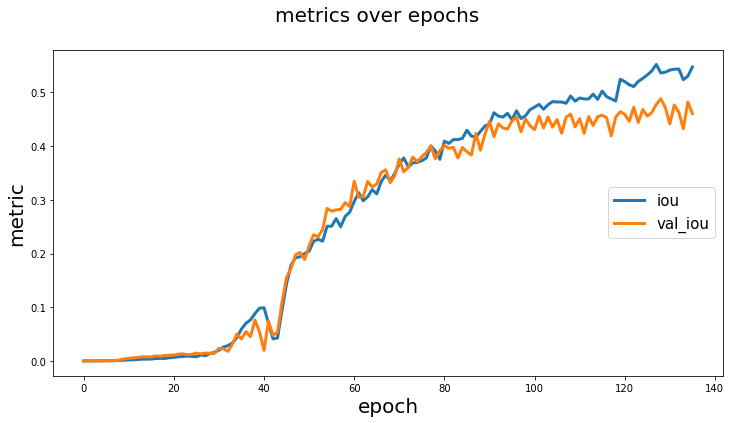

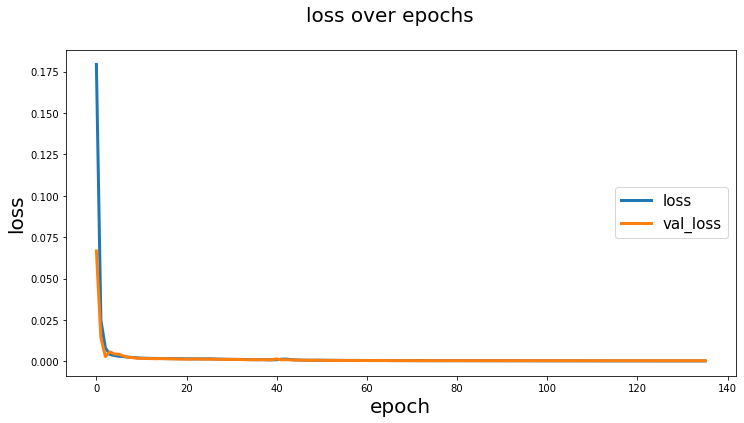

In [23]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [24]:
y_pred = model.predict(X_test)

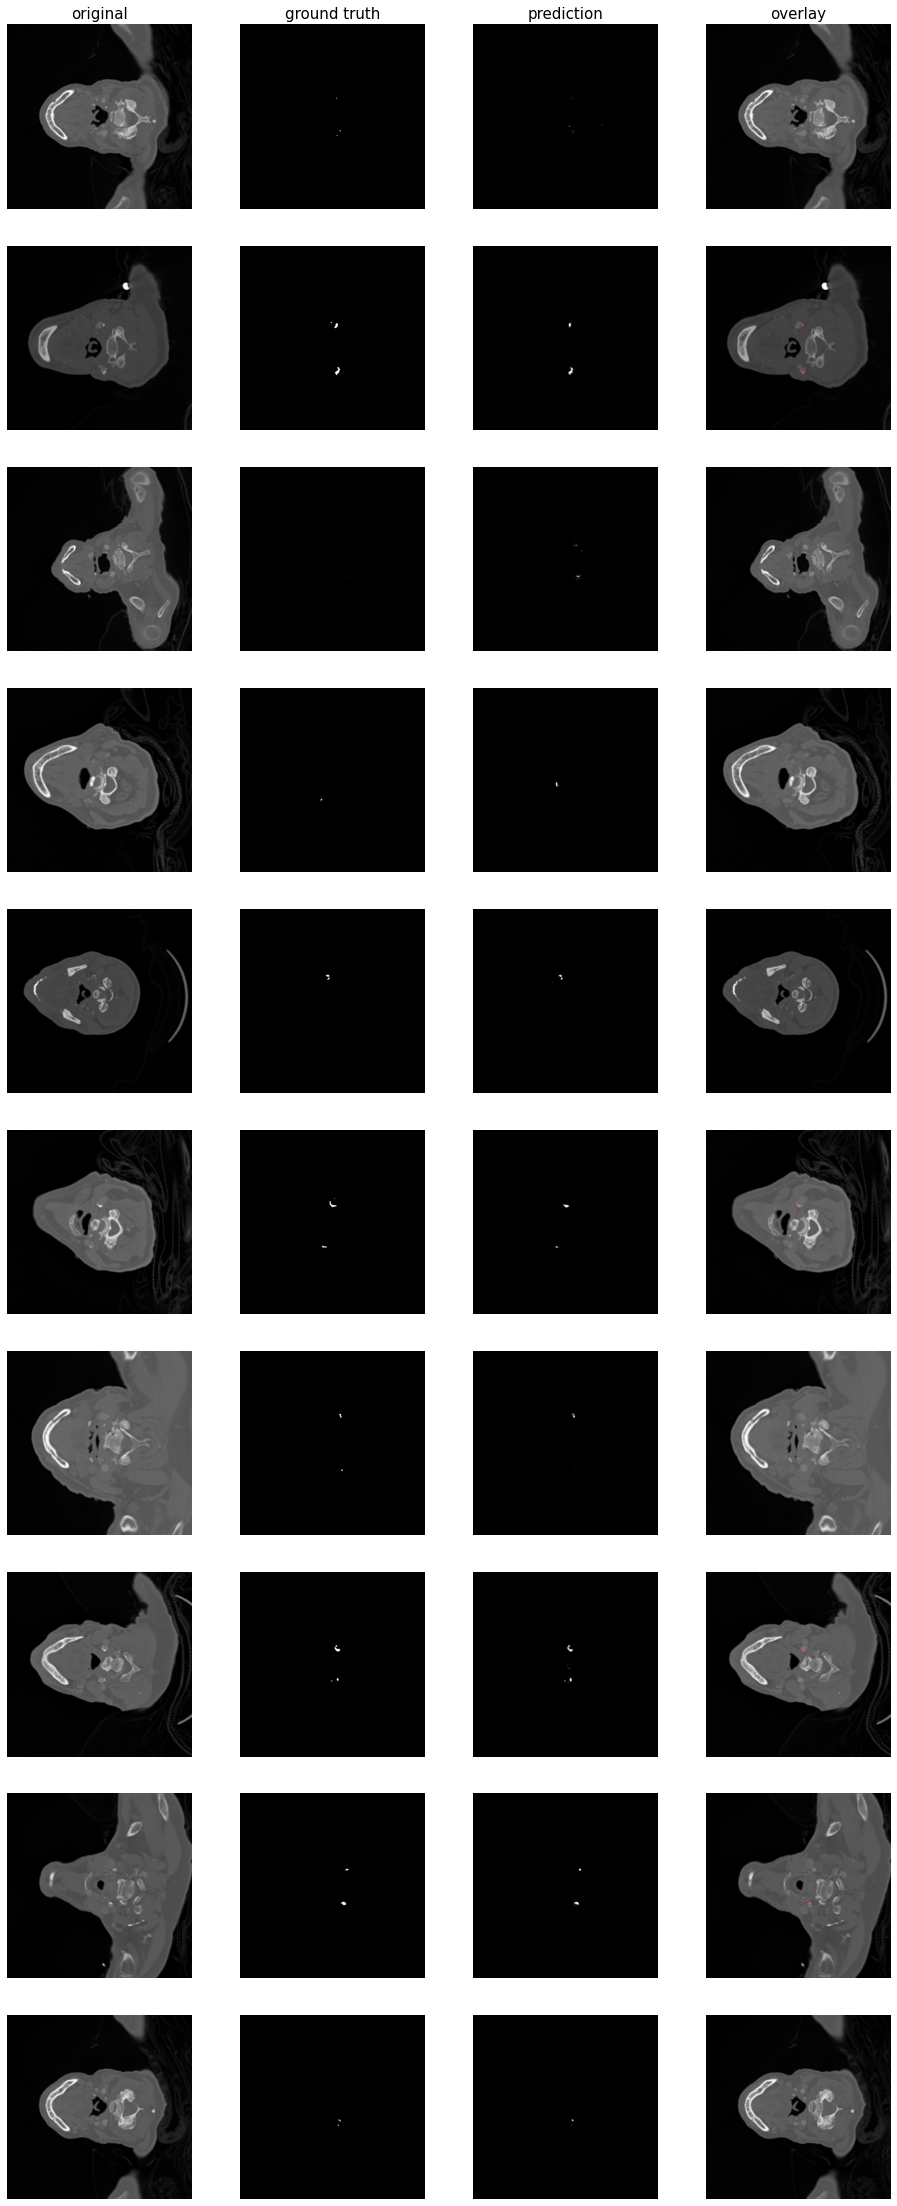

In [25]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [37]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 160ms/step - loss: 3.9631e-04 - iou: 0.4306 - iou_thresholded: 0.5425


In [27]:
import mahotas as mh

In [28]:
image = X_test[0]

In [29]:
image.shape

(512, 512, 1)

In [30]:
label = y_test[0]

In [31]:
pred = y_pred[0]

In [32]:
bbox = mh.bbox(label)
incr=30

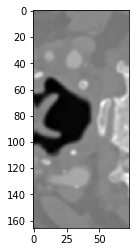

In [33]:
imshow(image[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:],cmap='gray')

In [34]:
X_test_c = []
y_test_c = []
y_pred_c = []

for i,z in enumerate(X_test):
    
    image = X_test[i]
    label = y_test[i]
    pred = y_pred[i]
    
    bbox = mh.bbox(label)
    incr=30
    X_test_c.append(image[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])
    y_test_c.append(label[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])
    y_pred_c.append(pred[bbox[0]-incr:bbox[1]+incr,bbox[2]-incr:bbox[3]+incr,:])


In [35]:
maxX = 0
maxY = 0

for i,z in enumerate(X_test_c):
    
    maxX = max(z.shape[1], maxX)
    maxY = max(z.shape[0], maxY)
    
X_test_c_np = np.zeros((len(X_test_c), maxY, maxX,1), dtype=X_test.dtype)
y_test_c_np = np.zeros((len(y_test_c), maxY, maxX,1), dtype=y_test.dtype)
y_pred_c_np = np.zeros((len(y_pred_c), maxY, maxX,1), dtype=y_pred.dtype)

for i,z in enumerate(X_test_c):
    
    image = X_test_c[i]
    label = y_test_c[i]
    pred = y_pred_c[i]
    
    X_test_c_np[i][0:image.shape[0], 0:image.shape[1],:] = image
    y_test_c_np[i][0:label.shape[0], 0:label.shape[1],:] = label
    y_pred_c_np[i][0:pred.shape[0], 0:pred.shape[1],:] = pred
    

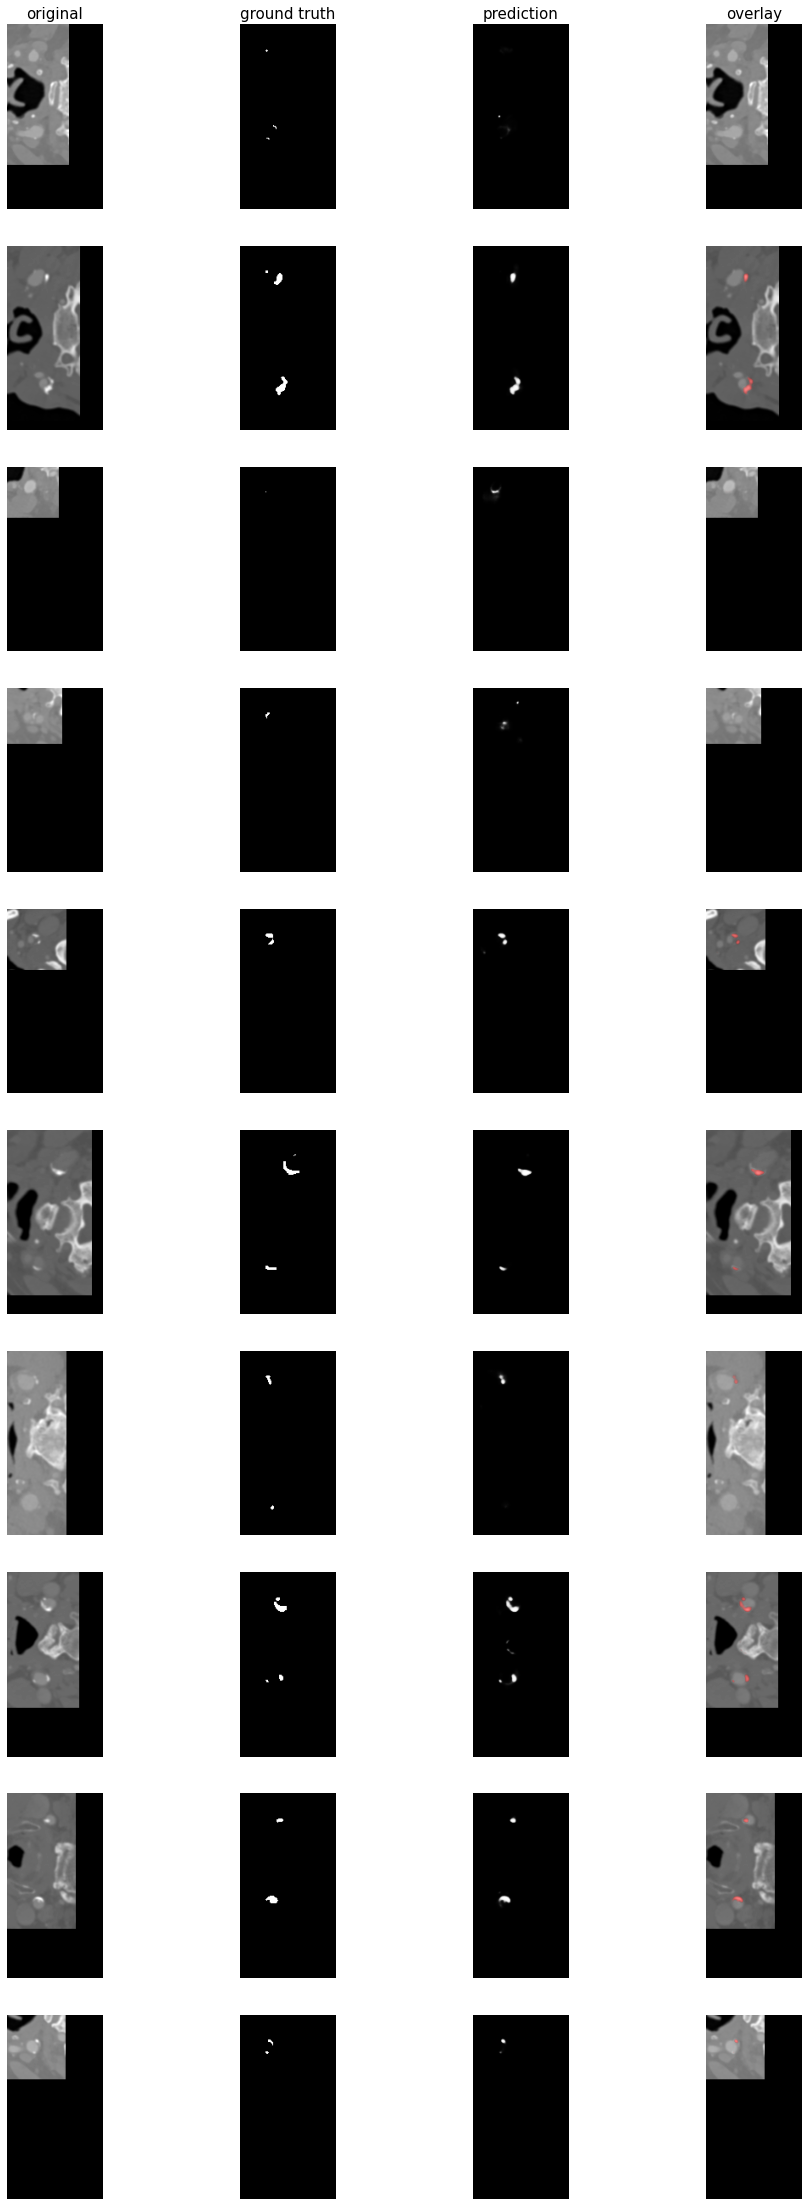

In [36]:
plot_imgs(org_imgs=X_test_c_np, mask_imgs=y_test_c_np, pred_imgs=y_pred_c_np)